# **Part 1**

## 1.1 Load and Process Data

In [0]:
import torch, torchvision
import numpy as np
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified


### Divide Data Into Training, Validation and Testing Sets

In [0]:
import numpy as np
#Prepare Data
X_train = np.array([trainset[i][0].numpy().flatten() for i in range(len(trainset))])
Y_train = np.squeeze(np.array([trainset[i][1] for i in range(len(trainset))]))

X_val = X_train[:5000]
Y_val = Y_train[:5000]

X_train = X_train[5000:]
Y_train = Y_train[5000:]

X_test = np.array([testset[i][0].numpy().flatten() for i in range(len(testset))])
Y_test = np.squeeze(np.array([testset[i][1] for i in range(len(testset))]))

array([[[ 0.20784318, -0.01176471, -0.17647058, ..., -0.2862745 ,
         -0.31764704, -0.38039213],
        [ 0.09803927,  0.13725495, -0.01960784, ..., -0.24705881,
         -0.3960784 , -0.44313723],
        [ 0.09803927,  0.09019613, -0.09803921, ..., -0.38039213,
         -0.46666664, -0.47450978],
        ...,
        [ 0.37254906,  0.22352946,  0.20784318, ..., -0.67058825,
         -0.52156866, -0.27058822],
        [ 0.2941177 ,  0.22352946,  0.24705887, ..., -0.19215685,
         -0.03529412,  0.02745104],
        [ 0.27843142,  0.23921573,  0.27843142, ...,  0.12156868,
          0.12156868,  0.12156868]],

       [[ 0.38823533,  0.07450986, -0.18431371, ..., -0.25490195,
         -0.29411763, -0.36470586],
        [ 0.254902  ,  0.20000005, -0.01960784, ..., -0.2235294 ,
         -0.372549  , -0.42745095],
        [ 0.21568632,  0.14509809, -0.09803921, ..., -0.35686272,
         -0.45098037, -0.4588235 ],
        ...,
        [ 0.30980396,  0.20784318,  0.254902  , ..., -

## 1.2 Build Fully Connected Network, Check Performance

### Build Neural Network Class

In [0]:
# Neural Network that uses ReLu activation and cross entropy loss
class NeuralNetwork:

    def __init__(self, layer_dimensions):
        # list of layer sizes e.g. [2,3,4]
        self.layers = layer_dimensions
        self.params = {} # Dictionnary where we will store weights and biases

        for layer in range(1, len(self.layers)):
            layer_input = self.layers[layer-1]
            layer_output = self.layers[layer]

            #weight matrices and biases
            self.params['W' + str(layer)] = np.random.randn(layer_output, layer_input )*0.1
            self.params['b' + str(layer)] = np.random.randn(layer_output, 1)*0.1

    #Transform labels into vectors of 1 and 0s. 1 for the label index, 0 for others.
    def one_hot_encode(self, labels):
        if len(labels) == 1:
            y = [1 if labels == i else 0 for i in range(10) ]
        
        else:
            y = [[1 if label == i else 0 for i in range(10) ] for label in labels]

        return np.array(y)

    #ReLu activation: A = relu(Z)
    def activationForward(self, Z):
        return np.maximum(0,Z)

    #affineForward(self, A, W, b) computes Z = W*A + b
    def affineForward(self, A, W, b):
        return self.activationForward( W @ A + b), W @ A  + b


    #Call affineForward() on each layer
    def forwardPropagation(self, X, cache):
        A_curr = X

        #for i in range(len(self.layers)):
        for layer in range(1, len(self.layers)):
            A_prev = A_curr
            W_curr = self.params["W" + str(layer)]
            b_curr = self.params["b" + str(layer)]
            A_curr, Z_curr = self.affineForward(A_prev, W_curr, b_curr)

            cache["A" + str(layer + 1)] = np.nan_to_num(A_prev)
            cache["Z" + str(layer)] = np.nan_to_num(Z_curr)

        result = np.array(self.softmax(A_curr))
        result = np.nan_to_num(result)


        return result, cache

    #Softmax function used for output layer
    def softmax(self, v):
        #m is a constant used to stop overflow
        m = np.max(v)
        result = np.nan_to_num(np.exp(v-m)/np.sum(np.exp(v-m),axis = 0))

        return result

    def probability_to_class(self, Y_hat):
        return np.argmax(Y_hat, axis = 0)
     

    # cross-entropy cost function
    # y is a list of correct labels
    def costFunction(self, Y_hat, Y):
        # compute cross-entropy loss from softmax
        N = Y.shape[0]
        Y = np.array(self.one_hot_encode(Y))
        epsilon = 2.220446049250313e-16
        loss = -(np.trace((Y @  np.log(Y_hat + epsilon))))
        return np.squeeze((1/N) * loss)

    def accuracy_rate(self, Y_hat, Y):
        Y_hat = self.probability_to_class(Y_hat)
        return np.mean((Y_hat == Y))


    def affineBackward(self, dA, A_prev, Z_curr, W_curr):
        N = A_prev.shape[1]
        dZ_curr = np.nan_to_num(self.activationBackward(dA, Z_curr))
        dW_curr = (1/N)*np.nan_to_num((dZ_curr @ A_prev.T))
        db_curr = (1/N)*np.nan_to_num(np.sum(dZ_curr, axis=1, keepdims=True))
        dA_prev = np.nan_to_num(W_curr.T @ dZ_curr)

        return dZ_curr, dW_curr, db_curr, dA_prev

    #Derivative of the RELU
    def activationBackward(self, dA, Z):
        dZ = np.array(dA, copy = True)
        return dZ*(Z>=0)

    #Backpropagation algorithm
    def backPropagation(self, Y_hat, Y, cache):
        grads = {}
        N = Y.shape[0]
        Y = np.array(self.one_hot_encode(Y))
        
        dA_prev = (Y_hat - Y.T)

        for layer in range(len(self.layers) - 1, 0,-1):
            
            dA_curr = dA_prev
            A_prev = cache["A" + str(layer + 1)]
            Z_curr = cache["Z" + str(layer)]
            W_curr = self.params["W" + str(layer)]
            b_curr = self.params["b" + str(layer)]

            dZ_curr, dW_curr, db_curr, dA_prev = self.affineBackward(dA_curr, A_prev, Z_curr, W_curr)
            #print(f"dZ: {dZ_curr.shape}, dA: {dA_prev.shape}, dW: {dW_curr.shape}, db: {db_curr.shape}")


            grads["dW" + str(layer)] = dW_curr
            grads["db" + str(layer)] = db_curr

        return grads

    #Gradient Descent Function
    def updateParameters(self, gradients, alpha):
        for layer in range(1, len(self.layers)):
            self.params["W" + str(layer)] -= alpha * gradients["dW" + str(layer)]
            self.params["b" + str(layer)] -= alpha * gradients["db" + str(layer)]
        return self.params



    def train(self, X_train, X_val, Y_train, Y_val, iters, alpha, batch_size):
        cost_history = []
        training_accuracy = []
        validation_accuracy = 0
        N_train = X_train.shape[1]

        #train
        for iter in range(iters):
          for batch in range(0, N_train, batch_size):
              #for iteration in range(iters):
              Y_hat, cache = self.forwardPropagation(X_train[:,batch:batch+batch_size], {})
              cost = self.costFunction(Y_hat, Y_train[batch:batch+batch_size])
              cost_history.append(cost)
              accuracy = self.accuracy_rate(Y_hat, Y_train[batch:batch+batch_size])
              training_accuracy.append(accuracy)
              if batch % 20000 == 0:
                  print(f"Epoch: {iter}: Batch {batch} - Before weight update - Current cost is: {cost} and current accuracy is {accuracy}")
              
              grads = self.backPropagation(Y_hat, Y_train[batch:batch+batch_size], cache)
              parameters = self.updateParameters(grads, alpha)
              Y_hat, cache = self.forwardPropagation(X_train[:,batch:batch+batch_size], {})
              cost = self.costFunction(Y_hat, Y_train[batch:batch+batch_size])
              accuracy = self.accuracy_rate(Y_hat, Y_train[batch:batch+batch_size])
              #print(parameters)
              if batch % 20000 == 0:
                  print(f"Batch: {batch} - After weight update - Current cost is: {cost} and current accuracy is {accuracy}")

        #validation

        Y_hat, cache = self.forwardPropagation(X_val, {})
        accuracy = self.accuracy_rate(Y_hat, Y_val)
        validation_accuarcy = accuracy



        return cost_history, training_accuracy, validation_accuracy


    def predict(self, X_new, cache = {}):
        result = self.forwardPropagation(X_new, cache)[0]
        return self.probability_to_class(result)
 


### Construct an Instance of Neural Network Class and Start Training

In [0]:
NN = NeuralNetwork([3072, 64, 24, 10])

#Training 
cost_hist, training_accu, validation_accu = NN.train(X_train.T, X_val.T, Y_train, Y_val, 30, 0.01, 25)

Epoch: 0: Batch 0 - Before weight update - Current cost is: 2.2914454609322044 and current accuracy is 0.24
Batch: 0 - After weight update - Current cost is: 2.267349811048641 and current accuracy is 0.24
Epoch: 0: Batch 20000 - Before weight update - Current cost is: 1.9856428813745668 and current accuracy is 0.36
Batch: 20000 - After weight update - Current cost is: 1.9438282570616596 and current accuracy is 0.4
Epoch: 0: Batch 40000 - Before weight update - Current cost is: 1.6519136753766466 and current accuracy is 0.44
Batch: 40000 - After weight update - Current cost is: 1.5775262242772274 and current accuracy is 0.52
Epoch: 1: Batch 0 - Before weight update - Current cost is: 1.7654616573156148 and current accuracy is 0.36
Batch: 0 - After weight update - Current cost is: 1.7277558405866893 and current accuracy is 0.4
Epoch: 1: Batch 20000 - Before weight update - Current cost is: 1.733344999961523 and current accuracy is 0.48
Batch: 20000 - After weight update - Current cost is

Final training loss is ~ 0.38 and final accuracy on last batch of the training set is 92%. The validation accuracy is: ~ 50.2% (code below) and test set accuracy is ~48.9% (code below). We build a model made of 2 hidden layers, 1 input layer and 1 output layer. The input layer has 3072 nodes (1 for each pixel), the first hidden layer has 64 nodes, the second layer has 24 nodes and finally the last layer has 10 nodes. Note that the end of the model we take the softmax of the output layer.

### Print Progress of Cost and Accuracy Over Iterations

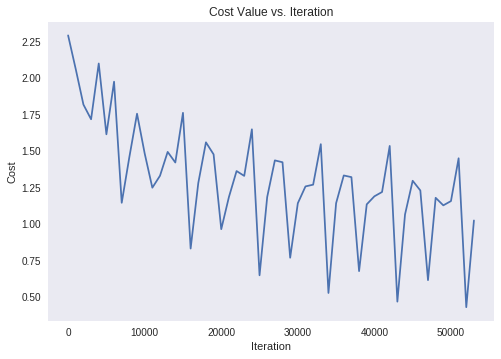

In [0]:
fig, ax = plt.subplots()
ax.plot([i for i in range(0,len(cost_hist),1000)], cost_hist[::1000])

ax.set(xlabel='Iteration', ylabel='Cost',
       title='Cost Value vs. Iteration')
ax.grid()

plt.show()

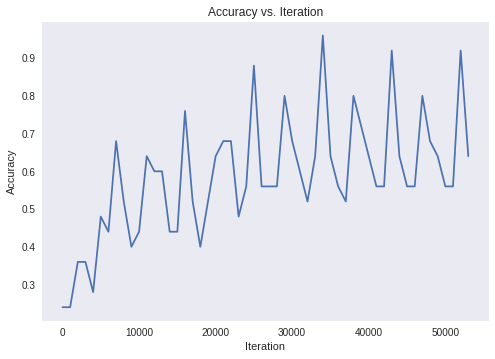

In [0]:
fig, ax = plt.subplots()
ax.plot([i for i in range(0,len(training_accu),1000)], training_accu[::1000])

ax.set(xlabel='Iteration', ylabel='Accuracy',
       title='Accuracy vs. Iteration')
ax.grid()

plt.show()

### Check Validation Accuracy

In [0]:
Y_hat, cache = NN.forwardPropagation(X_val.T, {})
validation_accuracy = NN.accuracy_rate(Y_hat, Y_val)
print(f"The validation accuracy is:{validation_accuracy}")

The validation accuracy is:0.502


### Check Test Set Accuracy

In [0]:
Y_hat, cache = NN.forwardPropagation(X_test.T, {})
test_accuracy = NN.accuracy_rate(Y_hat, Y_test)
print(f"The testing accuracy is {test_accuracy}")

The testing accuracy is 0.4894


## 1.3 Predict Item from Test Set

###Get Model Predictions for 5 Items

In [0]:
item_predictions = NN.predict(X_test[:5].T)

### Print Images and See predictions for Each

In [0]:
import matplotlib.pyplot as plt

legend = {0:"airplane", 1:"automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() 
  plt.imshow(np.transpose(npimg, (1, 2, 0)))


The image is that of a cat
The model predicted that is cat


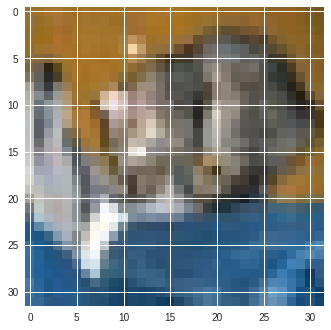

In [0]:
imshow(testset[0][0])
print(f"The image is that of a {legend[Y_test[0]]}")
print(f"The model predicted that is {legend[item_predictions[0]]}")

The image is that of a ship
The model predicted that is ship


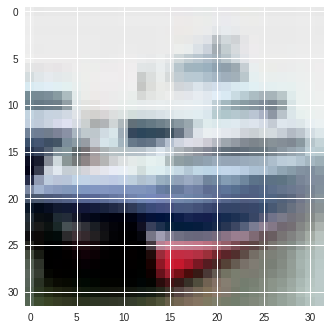

In [0]:
imshow(testset[1][0])
print(f"The image is that of a {legend[Y_test[1]]}")
print(f"The model predicted that is {legend[item_predictions[1]]}")

The image is that of a ship
The model predicted that is airplane


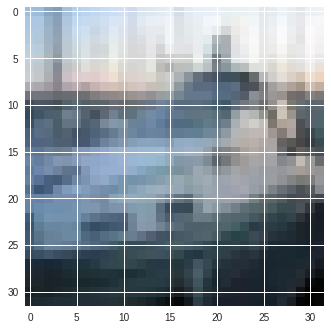

In [0]:
imshow(testset[2][0])
print(f"The image is that of a {legend[Y_test[2]]}")
print(f"The model predicted that is {legend[item_predictions[2]]}")

The image is that of a airplane
The model predicted that is airplane


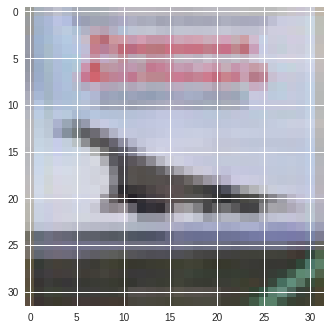

In [0]:
imshow(testset[3][0])
print(f"The image is that of a {legend[Y_test[3]]}")
print(f"The model predicted that is {legend[item_predictions[3]]}")

The image is that of a frog
The model predicted that is deer


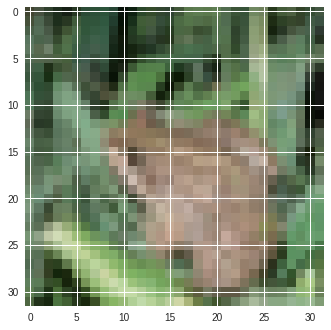

In [0]:
imshow(testset[4][0])
print(f"The image is that of a {legend[Y_test[4]]}")
print(f"The model predicted that is {legend[item_predictions[4]]}")

# **Part 2**

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=False, transform=transform)
trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,download=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainvalset, [45000, 5000]) # 10% for validation

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=1000, shuffle=False)

**First Model** - Basic CNN (adapted from PyTorch tutorial)

In [0]:
# This is basically the same model as the one used in the PyTorch Tutorial, applied to the CIFAR10 dataset
class CIFAR10_Model(nn.Module):
    def __init__(self):
        super(CIFAR10_Model, self).__init__()
        # input is 32x32x3
        # padding=2, same int used for height and width dimension
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)        
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64*8*8, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*8*8) # reshape before sending to fc layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # default p= 0.5
        x = self.fc2(x)
        return F.log_softmax(x)

In [0]:
model = CIFAR10_Model()
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

CIFAR10_Model(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


In [0]:
batch_size = 50

# send model to GPU
model.cuda()

model.train() # to set train mode for drop out
train_loss, train_accu = [], []
i = 0
for epoch in range(15):
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model(images)             # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Step: 0	Loss: 2.303	Accuracy: 6.000
Train Step: 1000	Loss: 1.240	Accuracy: 56.000
Train Step: 2000	Loss: 0.761	Accuracy: 76.000
Train Step: 3000	Loss: 0.638	Accuracy: 76.000
Train Step: 4000	Loss: 0.362	Accuracy: 84.000
Train Step: 5000	Loss: 0.651	Accuracy: 76.000
Train Step: 6000	Loss: 0.295	Accuracy: 90.000
Train Step: 7000	Loss: 0.238	Accuracy: 92.000
Train Step: 8000	Loss: 0.476	Accuracy: 88.000
Train Step: 9000	Loss: 0.133	Accuracy: 94.000
Train Step: 10000	Loss: 0.110	Accuracy: 94.000
Train Step: 11000	Loss: 0.099	Accuracy: 96.000
Train Step: 12000	Loss: 0.274	Accuracy: 92.000
Train Step: 13000	Loss: 0.210	Accuracy: 98.000


In [0]:
model.eval()
correct = 0
for images, labels in testloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
print(correct)
print('Test set accuracy: {:.2f}%'.format(100.0 * correct / len(testloader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(7494, device='cuda:0')
Test set accuracy: 74.00%


In [0]:
correct = 0
for images, labels in valloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()

print(correct)
print('Validation set accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(3754, device='cuda:0')
Validation set accuracy: 75.00%


In [0]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1, 2, 0)))


In [0]:
legend = {0:"airplane", 1:"automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
test_images = [testloader.dataset test_data[i] for i in range(len(testset))]
test_labels = testloader.dataset.test_labels

In [0]:
pred = []
lab = []
for images, labels in testloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        p = predictions.cpu().numpy()
        l = labels.cpu().numpy()
        for i in range(p.shape[0]):
            pred.append(p[i])
            lab.append(l[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
def test(i):
    imshow(testset[i][0])
    print("prediction:", legend[pred[i]])
    print("label:", legend[lab[i]])

ll = [i for i in range(10000) if legend[pred[i]] != legend[lab[i]]]
print(ll[:10])

[8, 12, 21, 24, 32, 33, 35, 37, 42, 47]


prediction: horse
label: horse


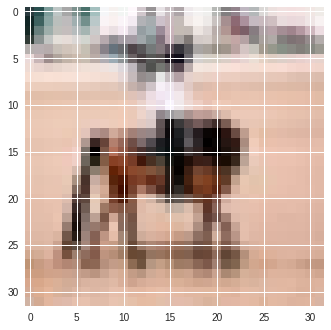

In [0]:
test(578)

prediction: truck
label: automobile


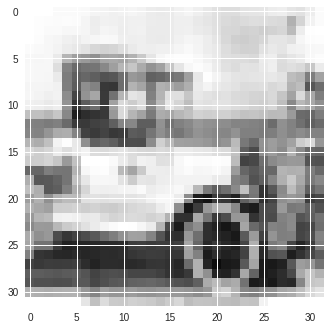

In [0]:
test(37)

prediction: bird
label: airplane


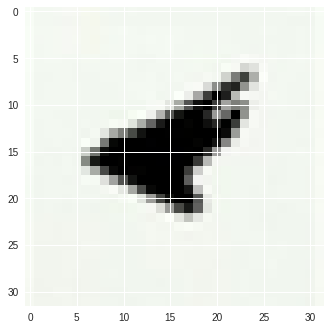

In [0]:
test(21)

prediction: cat
label: dog


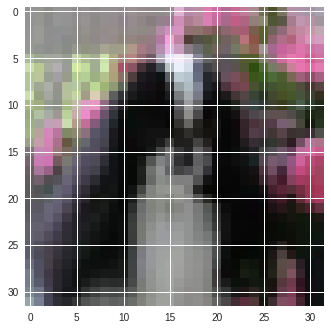

In [0]:
test(42)

prediction: bird
label: truck


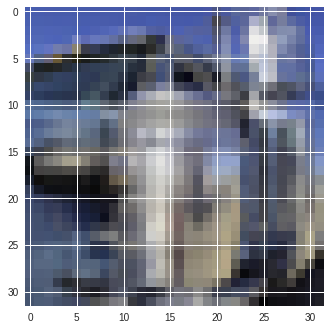

In [0]:
test(47)

prediction: truck
label: truck


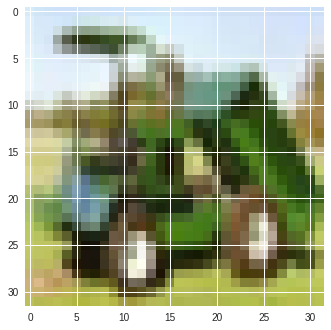

In [0]:
test(2019)

prediction: bird
label: dog


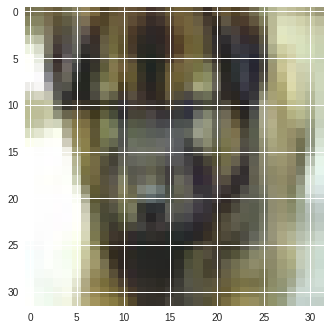

In [0]:
test(33)

prediction: deer
label: deer


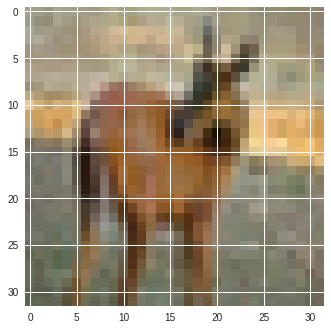

In [0]:
test(36)

In [0]:
class CIFAR10_Model(nn.Module):
    def __init__(self):
        super(CIFAR10_Model, self).__init__()
        # input is 3x32x32
        # padding=2, same int used for height and width dimension
        self.conv1 = nn.Conv2d(3, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 5, padding=2)
        self.conv4 = nn.Conv2d(256, 512, 5, padding=2)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.fc1 = nn.Linear(512*2*2, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048,10)
        
        self.bn11 = nn.BatchNorm1d(num_features=512)
        self.bn12 = nn.BatchNorm1d(num_features=1024)
        self.bn13 = nn.BatchNorm1d(num_features=2048)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = self.bn1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.bn2(x)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = self.bn3(x)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = self.bn4(x)
        
        x = x.view(-1, 512*2*2) # reshape before sending to fc layer
        x = F.relu(self.fc1(x))
        x = self.bn11(x)
        x = F.relu(self.fc2(x))
        x = self.bn12(x)
        x = F.relu(self.fc3(x))
        x = self.bn13(x)
        x = F.dropout(x, training=self.training)
        
        x = self.fc4(x)
        
        return F.log_softmax(x)

In [0]:
model = CIFAR10_Model()
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

CIFAR10_Model(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=10, bias=True)
  (bn11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=Tru

In [0]:
batch_size = 50

# send model to GPU
model.cuda()

model.train() # to set train mode for drop out
train_loss, train_accu = [], []
i = 0
for epoch in range(15):
    print("epoch: ", epoch+1)
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model(images)            # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        # accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        p = predictions.cpu().numpy()
        l = labels.cpu().numpy()
        # print(p,l)
        accuracy = np.sum(p==l)/batch_size*100
        
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1

epoch:  1
Train Step: 0	Loss: 2.395	Accuracy: 12.000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:  2
Train Step: 1000	Loss: 1.301	Accuracy: 52.000
epoch:  3
Train Step: 2000	Loss: 1.183	Accuracy: 70.000
epoch:  4
Train Step: 3000	Loss: 0.663	Accuracy: 82.000
epoch:  5
Train Step: 4000	Loss: 0.583	Accuracy: 80.000
epoch:  6
Train Step: 5000	Loss: 0.305	Accuracy: 92.000
epoch:  7
Train Step: 6000	Loss: 0.409	Accuracy: 86.000
epoch:  8
Train Step: 7000	Loss: 0.463	Accuracy: 86.000
epoch:  9
Train Step: 8000	Loss: 0.106	Accuracy: 98.000
epoch:  10
epoch:  11
Train Step: 9000	Loss: 0.039	Accuracy: 100.000
epoch:  12
Train Step: 10000	Loss: 0.057	Accuracy: 98.000
epoch:  13
Train Step: 11000	Loss: 0.037	Accuracy: 100.000
epoch:  14
Train Step: 12000	Loss: 0.018	Accuracy: 98.000
epoch:  15
Train Step: 13000	Loss: 0.027	Accuracy: 100.000


In [0]:
model.eval()
correct = 0
for images, labels in testloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
print(correct, correct/len(testloader.dataset))
print('Test set accuracy: {:.2f}%'.format(100.0 * correct / len(testloader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(7754, device='cuda:0') tensor(0, device='cuda:0')
Test set accuracy: 77.00%


In [0]:
correct = 0
for images, labels in valloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()

print(correct)
print('Validation set accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(3934, device='cuda:0')
Validation set accuracy: 78.00%


In [0]:
pred = []
lab = []
for images, labels in testloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        p = predictions.cpu().numpy()
        l = labels.cpu().numpy()
        for i in range(p.shape[0]):
            pred.append(p[i])
            lab.append(l[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1, 2, 0)))
    
legend = {0:"airplane", 1:"automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
test_images = [testloader.dataset.test_data[i] for i in range(len(testset))]
test_labels = testloader.dataset.test_labels

def test(i):
    imshow(testset[i][0])
    print("prediction:", legend[pred[i]])
    print("label:", legend[lab[i]])

ll = [i for i in range(10000) if legend[pred[i]] != legend[lab[i]]]
print(ll[50:60])

[238, 242, 245, 247, 248, 254, 255, 256, 258, 259]


prediction: cat
label: dog


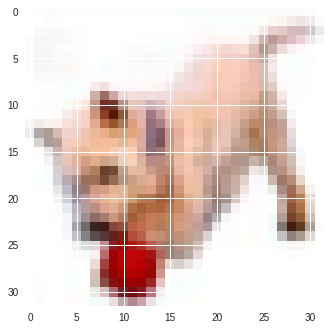

In [0]:
test(238)

prediction: dog
label: dog


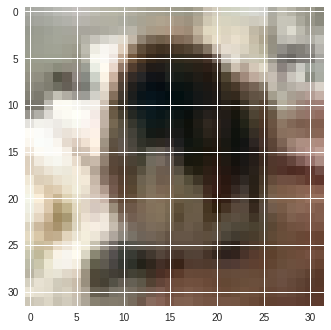

In [0]:
test(200)

prediction: ship
label: airplane


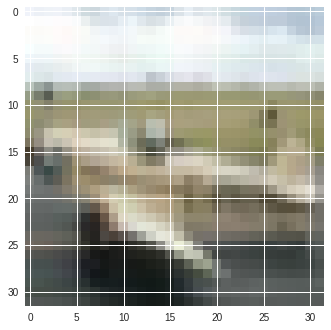

In [0]:
test(258)

prediction: cat
label: horse


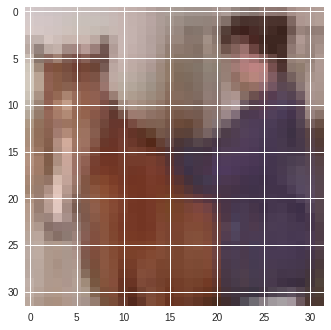

In [0]:
test(567)

prediction: frog
label: frog


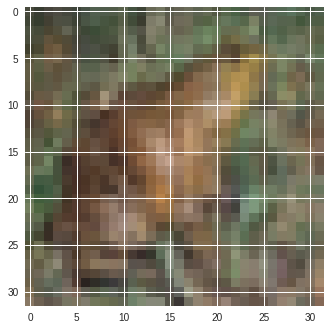

In [0]:
test(593)

In [0]:
class CIFAR10_Model(nn.Module):
    def __init__(self):
        super(CIFAR10_Model, self).__init__()
        # input is 3x32x32
        # padding=2, same int used for height and width dimension
        self.conv1 = nn.Conv2d(3, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 5, padding=2)
        self.conv4 = nn.Conv2d(256, 512, 5, padding=2)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.fc1 = nn.Linear(512*2*2, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048,10)
        
        self.bn11 = nn.BatchNorm1d(num_features=512)
        self.bn12 = nn.BatchNorm1d(num_features=1024)
        self.bn13 = nn.BatchNorm1d(num_features=2048)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = self.bn1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.bn2(x)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = self.bn3(x)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = self.bn4(x)
        
        x = x.view(-1, 512*2*2) # reshape before sending to fc layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.bn11(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.bn12(x)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.bn13(x)
        
        x = self.fc4(x)
        
        return F.log_softmax(x)

In [0]:
model = CIFAR10_Model()
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

CIFAR10_Model(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=10, bias=True)
  (bn11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=Tru

In [0]:
batch_size = 50

# send model to GPU
model.cuda()

model.train() # to set train mode for drop out
train_loss, train_accu = [], []
i = 0
for epoch in range(15):
    print("epoch: ", epoch+1)
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model(images)            # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        # accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        p = predictions.cpu().numpy()
        l = labels.cpu().numpy()
        # print(p,l)
        accuracy = np.sum(p==l)/batch_size*100
        
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1

epoch:  1
Train Step: 0	Loss: 2.358	Accuracy: 12.000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:  2
Train Step: 1000	Loss: 1.347	Accuracy: 54.000
epoch:  3
Train Step: 2000	Loss: 0.859	Accuracy: 68.000
epoch:  4
Train Step: 3000	Loss: 0.815	Accuracy: 70.000
epoch:  5
Train Step: 4000	Loss: 0.827	Accuracy: 72.000
epoch:  6
Train Step: 5000	Loss: 0.531	Accuracy: 84.000
epoch:  7
Train Step: 6000	Loss: 0.627	Accuracy: 80.000
epoch:  8
Train Step: 7000	Loss: 0.291	Accuracy: 90.000
epoch:  9
Train Step: 8000	Loss: 0.648	Accuracy: 86.000
epoch:  10
epoch:  11
Train Step: 9000	Loss: 0.056	Accuracy: 100.000
epoch:  12
Train Step: 10000	Loss: 0.120	Accuracy: 96.000
epoch:  13
Train Step: 11000	Loss: 0.096	Accuracy: 94.000
epoch:  14
Train Step: 12000	Loss: 0.040	Accuracy: 98.000
epoch:  15
Train Step: 13000	Loss: 0.129	Accuracy: 96.000


In [0]:
model.eval()
correct = 0
for images, labels in testloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
print(correct, correct/len(testloader.dataset))
print('Test set accuracy: {:.2f}%'.format(100.0 * correct / len(testloader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(7936, device='cuda:0') tensor(0, device='cuda:0')
Test set accuracy: 79.00%


In [0]:
correct = 0
for images, labels in valloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()

print(correct)
print('Validation set accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(3972, device='cuda:0')
Validation set accuracy: 79.00%


In [0]:
pred = []
for images, labels in testloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        p = predictions.cpu().numpy()
        l = labels.cpu().numpy()
        for i in range(p.shape[0]):
            pred.append(p[i])

ll = [i for i in range(10000) if legend[pred[i]] != legend[lab[i]]]
print(ll[10:20])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[56, 57, 58, 61, 71, 74, 76, 85, 86, 87]


prediction: frog
label: automobile


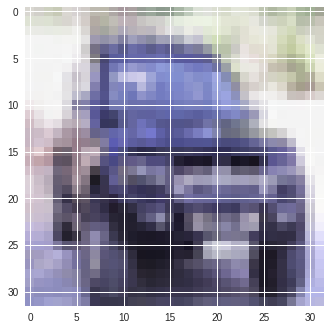

In [0]:
test(9)

prediction: frog
label: cat


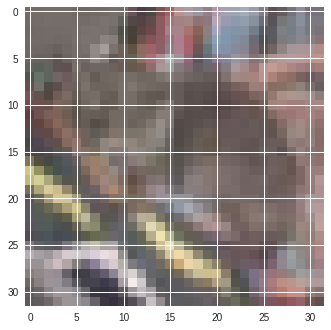

In [0]:
test(2018)

prediction: cat
label: cat


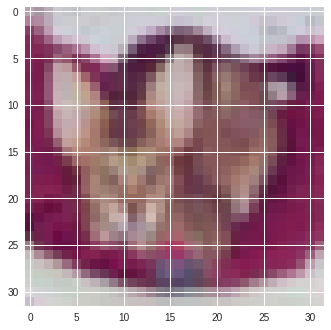

In [0]:
test(1030)

prediction: ship
label: airplane


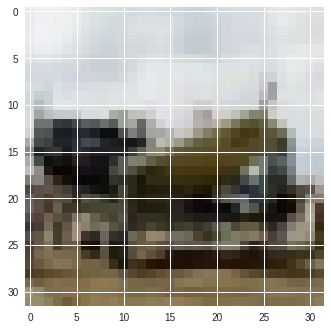

In [0]:
test(74)

prediction: horse
label: dog


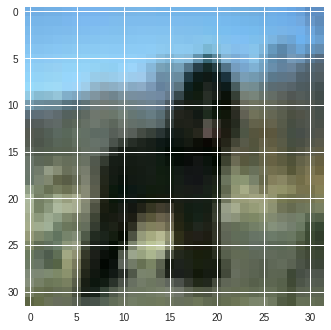

In [0]:
test(85)

prediction: ship
label: ship


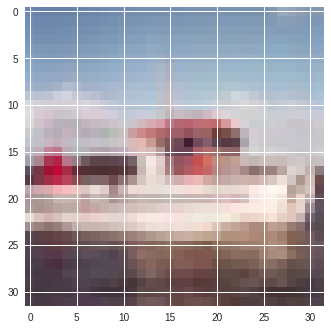

In [0]:
test(1508)

**Discussion**

We have three models: the first is the original CNN model from the PyTorch tutorial with 2 convolutional layers and two fully connected layers, using ReLu activation. The second model is like the first except that it has more convolutional layers, more fully connected layers, and batch normalization layers (4 each). The third model is like the second except that there are dropout layers in between the fully connected layers.

The results:

Model: 1

The training loss, training accuracy, validation accuracy, and test accuracy were 0.210, 98%, 75.08%, and 74.94%, respectively.

Model 2:

The training loss, training accuracy, validation accuracy, and test accuracy were 0.027, 100%, 78.68% and 77.54% respectively.

Model 3:

The training loss, training accuracy, validation accuracy, and test accuracy were 0.129, 96%, 79.44, and 79.36, respectively.


There is a notable difference between the accuracy of the first and second models, so this suggests that addition of more convolutional layers and fully connected layers can improve accuracy. There was a much smaller difference between the second and third models, but it may be significant because the only difference was the addition of a few dropout layers.